In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

rcParams['figure.figsize'] = 12, 6

df = pd.read_csv("./data.csv")                     
df.request_date = pd.to_datetime(df.request_date)    # convert string index to datetime (for decomposition)
df.set_index('request_date', inplace=True)
df.head()

,requests,Temperature,Precipitation,WindSpeed
request_date,,,,
2015-09-01 00:00:00,709,16.0,0.0,17.0
2015-09-01 01:00:00,480,16.0,0.0,17.0
2015-09-01 02:00:00,498,15.0,0.0,18.0
2015-09-01 03:00:00,567,15.0,0.0,18.0
2015-09-01 04:00:00,361,16.0,0.0,15.0


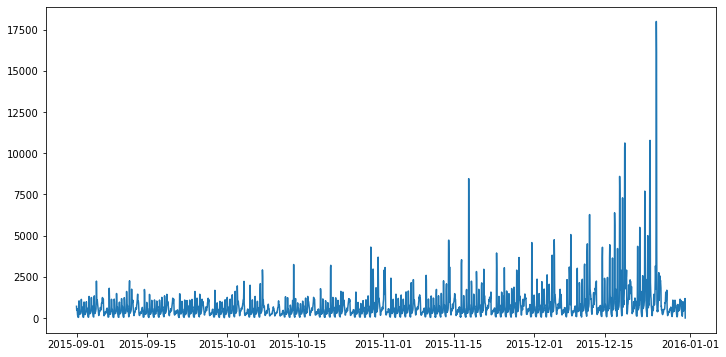

In [2]:
plt.plot(df['requests'])

## Differencing

In [3]:
def difference(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset["requests"][i] - dataset["requests"][i - interval]
        diff.append(value)
    return (diff)

def adf_test(timeseries):   
    dftest = adfuller(timeseries, autolag='AIC')   # fail to reject H0: TS is non-stationary - time structure exists
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #print (dfoutput) 
    return dfoutput

def makeStationary(df):
    d=-1
    temp = df
    for i in range(10):
        pvalue = adf_test(temp)[1]           # stationary
        if pvalue<=0.05:
            d=i
            return temp, d
        else:
            temp = difference(temp,i+1)
    if d==-1:
        print("Something's wrong")
        return -1, -1
    
data, d = makeStationary(df['requests'])
print(d)

0


## TS Decomposition

c:\users\giorg\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


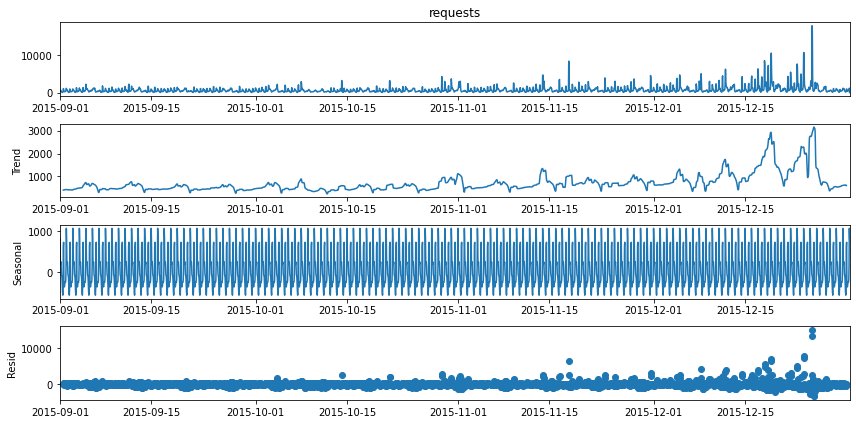

In [4]:
additive = seasonal_decompose(data, model='additive', freq=24)    # freq is every how many dps we observe the same shit
#multiplicative = seasonal_decompose(diff_1, model='multiplicative', freq=12)    # freq is every how many dps we observe the same shit

trend = additive.trend
seasonal = additive.seasonal
residual = additive.resid

additiveplot = additive.plot()

In [5]:
trend.isnull().values.any(), seasonal.isnull().values.any(), residual.isnull().values.any() # Only seasonal component

(True, False, True)

## SARIMA

There are three ARIMA elements that require configuration:

    p: Trend autoregression order -> lag order (how many time steps to include)     (refers to AR component)
    d: Trend difference order -> order of differencing that made the TS stationary. (refers to I component)
    q: Trend moving average order -> the size of the moving average window          (refers to MA component)

Seasonal Elements

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

    P: Seasonal autoregressive order.
    D: Seasonal difference order.
    Q: Seasonal moving average order.
    m: The number of time steps for a single seasonal period.
    
e.g SARIMA(p,d,q)(P,D,Q)m : m represents the seasonal cycle, e.g. 12 is yearly


## AR process - Discover p: PACF plot

- PACF plot finds correlation of the residuals

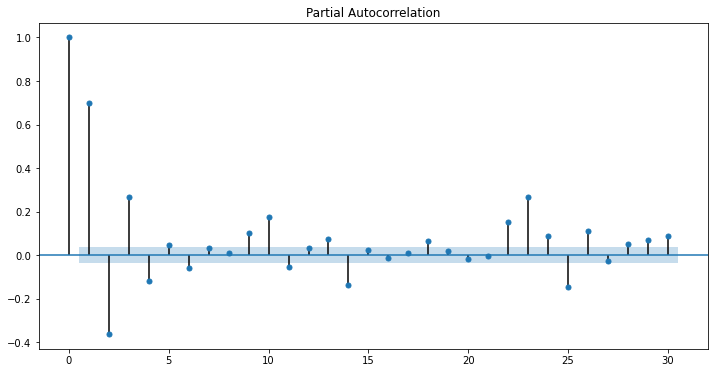

In [6]:
pacf_plot = plot_pacf(data, lags=30)

Based on the above graph: 
-     We choose (PACF plot): p based on lags before it cuts the upper bound)

In [7]:
p = 1

## MA process - Discover q: ACF plot

- describes how well the present value of the series is related with its past values, considers trend,seasonality and residual while finding correlations hence it’s a ‘complete auto-correlation plot’

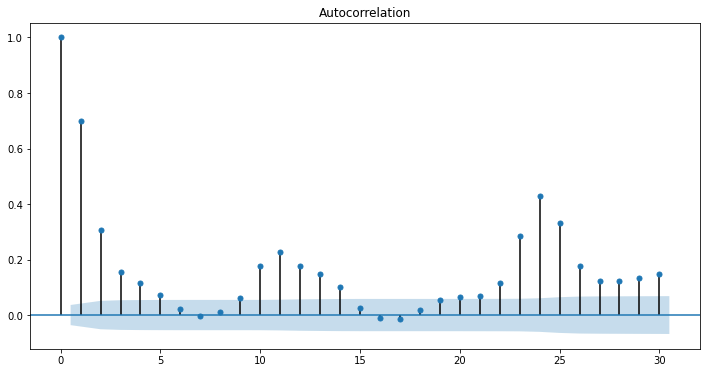

In [8]:
acf_plot = plot_acf(data, lags=30)

Based on the above graph:
-     We choose (ACF plot): q based on lags before it cuts the upper bound

In [9]:
q = 5

# Seasonal Component 

## 1 - D

In [10]:
useless, D = makeStationary(seasonal)
print(D)

0


# 2 - P

c:\users\giorg\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


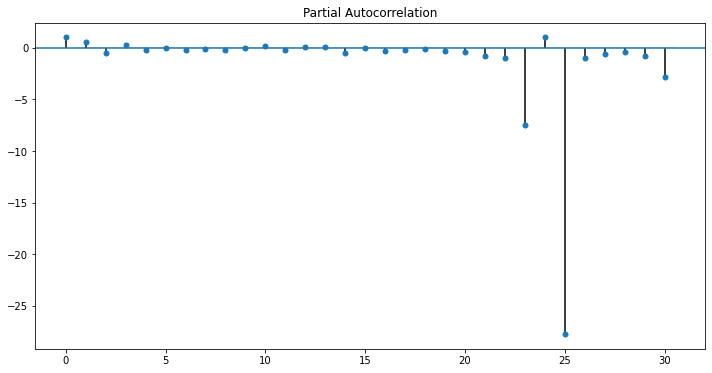

In [12]:
pacf_plot = plot_pacf(seasonal, lags=30)

In [13]:
P = 1

# 3 - Q

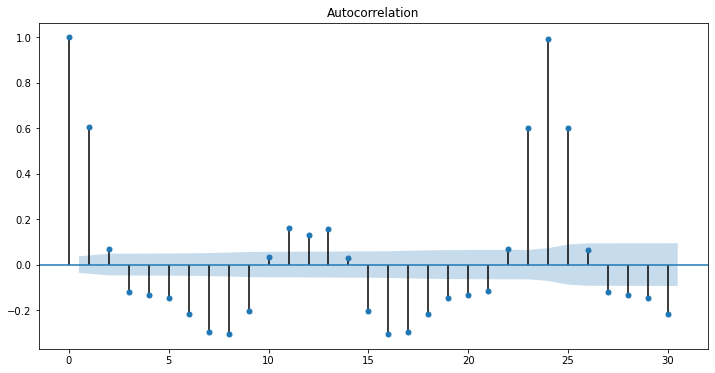

In [15]:
acf_plot = plot_acf(seasonal, lags=30)

In [16]:
Q = 2

In [17]:
s = 24     # periodicity - every how many observations seasonality repeats itself

# Fits

In [18]:
stepsOut = 125

train = data[:-(stepsOut)]
test = data[-(stepsOut):]

exog = df[['Temperature', 'Precipitation', 'WindSpeed']]
exog_train = exog[:-(stepsOut)]
exog_test = exog[-(stepsOut):] 

## 1 AR Fit & Predict

c:\users\giorg\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


MAE is: 364.0712890519534


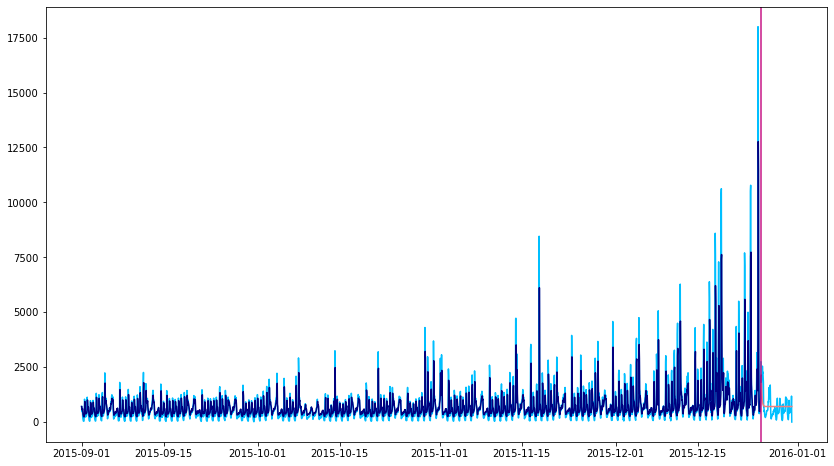

In [53]:
model = ARIMA(train, order=(p,d,0))    # Since we only fit AR, q=0
result = model.fit(disp=False)
#print(result.summary())               # export

# Fit
trainpreds = result.fittedvalues

# Predict

testpreds = result.predict(start=test.index[0], end=test.index[0-1])   # should be the same

# Forecast - quite the same

# forecast = result.forecast(steps=stepsOut)[0]
# testpreds = []
# hours=0
# for yhat in forecast:
#     #inverted = inverse_difference(history, yhat, days_in_year)        # in case TS was differenced
#     #print('Day %d: %f' % (day, inverted))
#     testpreds.append(yhat)
#     hours += 1

    
# Evaluate
score = mean_absolute_error(test, testpreds)
print("MAE is: "+str(score))

# Plot
rcParams['figure.figsize'] = 14, 8
plt.plot(data, color='deepskyblue')
plt.plot(trainpreds, color='navy')
plt.plot(testpreds, color='lightcoral')
plt.axvline(x=test.index[0], label='train/test split', c='mediumvioletred')
plt.show()

## 2 MA Fit & Predict

c:\users\giorg\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


MAE is: 201.01870227521943


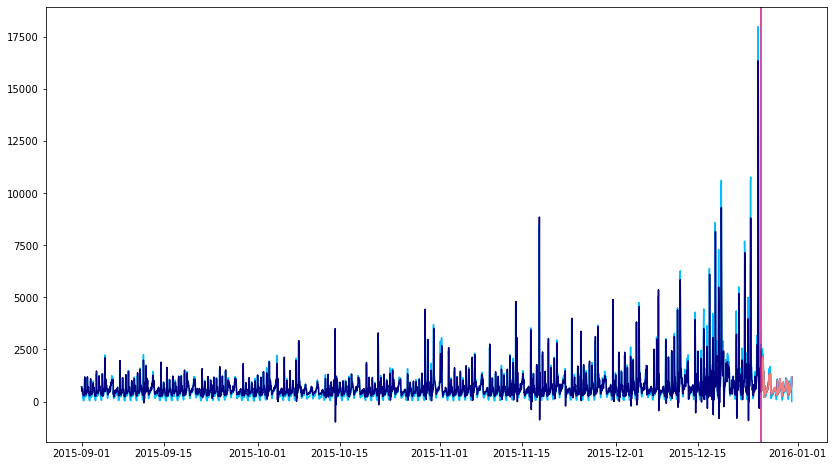

In [56]:
model = ARIMA(data, order=(0,d,q))    # Since we only fit AR, q=0
result = model.fit(disp=False)
#print(result.summary())

# Fit
trainpreds = result.fittedvalues
testpreds = result.predict(start=test.index[0], end=test.index[0-1])

# Evaluate
score = mean_absolute_error(test, testpreds)
print("MAE is: "+str(score))

# Plot
rcParams['figure.figsize'] = 14, 8
plt.plot(data, color='deepskyblue')
plt.plot(trainpreds, color='navy')
plt.plot(testpreds, color='lightcoral')
plt.axvline(x=test.index[0], label='train/test split', c='mediumvioletred')
plt.show()

## 3 SARIMA Fit & Predict

In [153]:
s=24

c:\users\giorg\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
c:\users\giorg\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
c:\users\giorg\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MAE is: 932.4295941918404


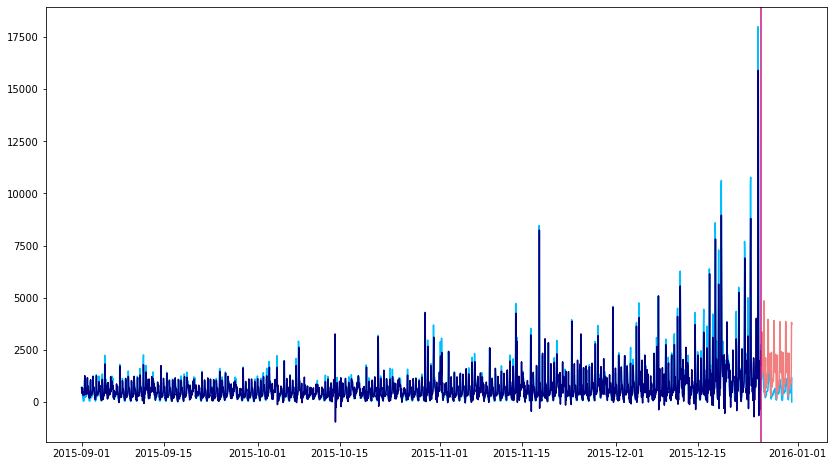

In [60]:
model = SARIMAX(train, order=(p,d,q),seasonal_order=(P,D,Q,s), exog=exog_train)  
result = model.fit(disp=False)
#print(result.summary())

# Fit
trainpreds = result.fittedvalues
testpreds = result.predict(start=test.index[0], end=test.index[0-1], exog=exog_test)

# Evaluate
score = mean_absolute_error(test, testpreds)
print("MAE is: "+str(score))

# Plot
rcParams['figure.figsize'] = 14, 8
plt.plot(data, color='deepskyblue')
plt.plot(trainpreds, color='navy')
plt.plot(testpreds, color='lightcoral')
plt.axvline(x=test.index[0], label='train/test split', c='mediumvioletred')
plt.show()

# MISC

- If diff_1 IS stationary, we can either do ARMA on it, or ARIMA (with 1 level of integration: d=1) to the initial TS
- Another option would be to extract the residuals from the decomposition and use that with d=0